In [84]:
import os, sys
# for accessing src, stan, etc.
sys.path.append(os.path.abspath(os.path.join("../..")))

import bayesflow as bf
import numpy as np
from src.AmortizedMixture import *
from src.models.NormalHmm import *


import matplotlib.pyplot as plt
from src.helpers import plot_bands

In [2]:
model = NormalHmm(n_cls = 2, n_obs=[100, 100], separation=3.0)
model.prior_means = [0.0, 0.0, -1.5, 1.00]
model.prior_sds = [1.14,  1.14, 1.0, 0.65]

# Load pretrained models

## Amortized filtering

In [3]:
filtering = bf.trainers.Trainer(
    amortizer=AmortizedMixture(
        inference_net=DependentClassificator(num_outputs=model.n_cls, bidirectional=False),
        global_summary_net=bf.networks.SequenceNetwork(summary_dim=model.n_par*2)
    ), 
    generative_model=model, 
    checkpoint_path="checkpoints/filtering", 
    configurator=lambda x: x)

INFO:root:Loaded loss history from checkpoints/filtering/history_8.pkl.
INFO:root:Networks loaded from checkpoints/filtering/ckpt-8
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [75]:
filtering_posterior = bf.trainers.Trainer(
    amortizer = AmortizedMixturePosterior(
        amortized_mixture = AmortizedMixture(
            inference_net = DependentClassificator(num_outputs=model.n_cls, bidirectional=False)
        ),
        amortized_posterior = AmortizedPosterior(
            inference_net = bf.networks.InvertibleNetwork(num_params=model.n_par, num_coupling_layers=10, coupling_design="spline"),
            summary_net = bf.networks.SequenceNetwork(summary_dim=model.n_par*2),
            summary_loss_fun = "MMD"
        )  
    ),
    generative_model = model,
    checkpoint_path = "checkpoints/filtering_posterior",
    configurator = lambda x: x
)

INFO:root:Loaded loss history from checkpoints/filtering_posterior/history_50.pkl.
INFO:root:Networks loaded from checkpoints/filtering_posterior/ckpt-50
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Experiment: Estimating state probabilities (clear cut case)

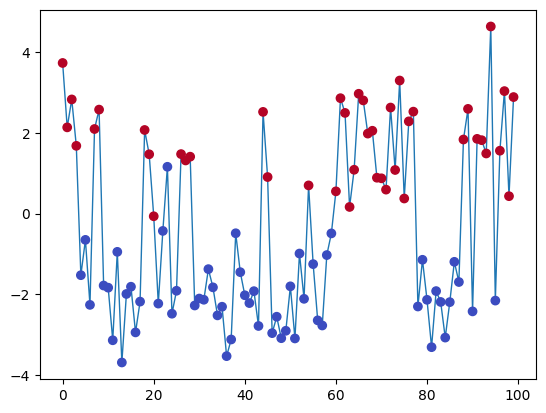

In [104]:
parameters = {
    "p": [np.array([0.8, 0.2]), np.array([0.3, 0.7])],
    "mu": np.array([-2, 2])
}
context = {
    "n_obs": 100
}
latents, observables = model._simulator(
    parameters=parameters, 
    context=context).values()

plt.plot(observables, linewidth=1, zorder=-1)
plt.scatter(range(len(observables)), observables, c=latents, cmap='coolwarm')

In [105]:
bf_data = model.config_bayesflow(context, observables)

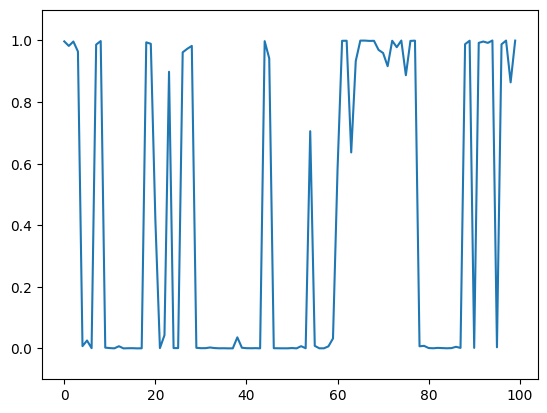

In [106]:
filtering_probs = np.array(filtering.amortizer(bf_data)[0,:,1])
f=plt.plot(filtering_probs)
f=plt.ylim((-0.1,1.1))

In [108]:
_, filtering_posterior_probs = filtering_posterior.amortizer.sample(bf_data, n_samples=1000)
filtering_posterior_probs = filtering_posterior_probs[0,:,:,1]

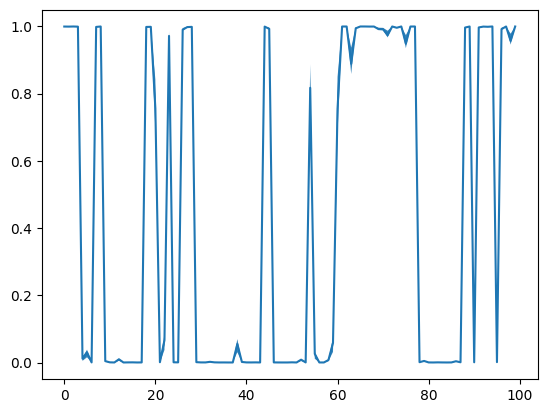

In [115]:
plt.plot(np.mean(filtering_posterior_probs, axis=0))
plot_bands(range(len(observables)), filtering_posterior_probs, alpha=0.9)

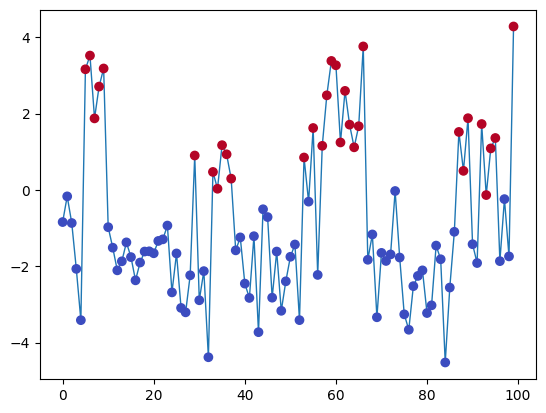

In [49]:
f=plt.plot(observables, linewidth=1, zorder=-1)
f=plt.scatter(range(len(observables)), observables, c=latents, cmap='coolwarm')

## Experiment: Estimating stat probabilities (not clear cut)

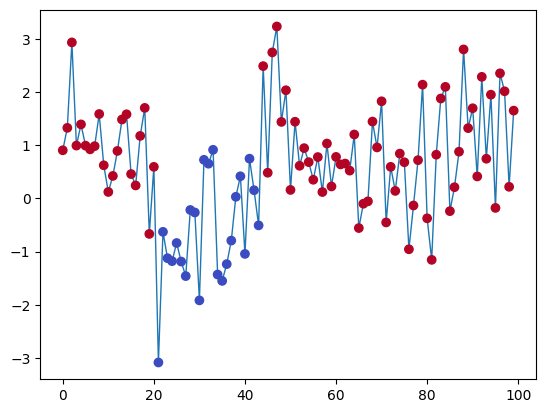

In [72]:
parameters = {
    "p": [np.array([0.99, 0.01]), np.array([0.01, .99])],
    "mu": np.array([-0.5, 1])
}
context = {
    "n_obs": 100
}
latents, observables = model._simulator(
    parameters=parameters, 
    context=context).values()

plt.plot(observables, linewidth=1, zorder=-1)
plt.scatter(range(len(observables)), observables, c=latents, cmap='coolwarm')

In [73]:
bf_data = model.config_bayesflow(context, observables)

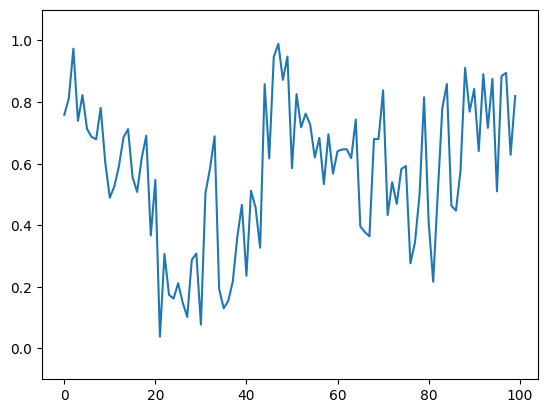

In [74]:
filtering_probs = np.array(filtering.amortizer(bf_data)[0,:,1])
f=plt.plot(filtering_probs)
f=plt.ylim((-0.1,1.1))